# Hydro unit commitment problem

## Introduction

Given a set of production units, the unit commitment problem consists in determining the status (on/off) of each unit at each period as well as the quantity of electricity to produce, in order to maximize the profit or satisfy demands while minimizing operational costs.

Here, we focus on hydropower generation.

The powerhouse contains a turbine and a generator. The water goes from the upstream reservoir to the downstream river through the penstock, passing by the powerhouse. The flow of water through the pales of a turbine generates electricity which is then transferred from the generator to its final destination through the long distance power lines. The water that passes through the penstock is used to generate power, but water could also be released from the reservoir directly to the downstream river. This water is said to be spilled, as it is not used for production, but rather to avoid an overflow
of the reservoir.

![schema_hydro_leg.png](schema_hydro_leg.png)
Image source: https://commons.wikimedia.org/wiki/File:Hydroelectric_dam-es.svg

The quantity of electricity $p_{j, t}$ produced by turbine $j$ at period $t$ is a nonlinear function of the net head $h^{net}_{t}$ and the water discharge $q_{j,t}$:

$$
		p_{j,t} = \eta_j \cdot q_{j,t} \cdot h^{net}_{t}
$$
where $\eta_j$ is called the efficiency of turbine $j$.

## Problem description

Here, we consider a problem composed of **several turbines and one reservoir**. The objective is to **maximize the revenue from selling generated power**.

**Input**:
* $H$ periods; for each period $t = 1, \dots, H$
  * a profit $R_t$ for selling a unit of electricty
  * an inflow $\Omega_t$
* $N$ turbines; for each turbine $i = 1, \dots, N$:
  * a minimum discharge $Q^\text{min}_j$
  * a maximum discharge $Q^\text{max}_j$
  * a minimum production $P^\text{min}_j$
  * a maximum production $P^\text{max}_j$
  * an efficiency $\eta_i$
* a minimum volume $V^\text{min}$ for the reservoir
* a maximum volume $V^\text{max}$ for the reservoir
* an initial volume $V^\text{init}$ for the reservoir
* a minimum final $V^\text{final}$ volume for the reservoir
* a function $F^\text{head}(v) = A^\text{head} v + B^\text{head}$ that returns the headwater depending on the volume in the reservoir
* a function $F^\text{tail}(q, s) = A^\text{tail}_q q + A^\text{tail}_s s + B^\text{tail}$ that returns the tailwater depending on the water discharge and the spilled water

**Problem**: find the quantity of water to send in each turbine at each period such that:
* The volume in the reservoir always stays in $[V^\text{min}, V^\text{max}]$
* The initial volume is equal to $V^\text{init}$
* The final volume is greater than $V^\text{final}$
* If a turbin is used
  * the water discharge in this turbine belongs to $[Q^\text{min}, Q^\text{max}]$; otherwise, it is null.
  * the production of this turbine belongs to $[P^\text{min}, P^\text{max}]$; otherwise, it is null.

**Objective**: maximize the profit

## Mixed-integer nonlinear program

**Variables**:

* $x_{j, t} \in \{ 0, 1 \}$, $j = 1, \dots, N$, $t = 1, \dots, H$: $x_{j, t} = 1$ iff turbine $j$ is on at period $t$, otherwise $0$.
* $q_{j, t} \in [0, Q_j^\text{max}]$, $j = 1, \dots, N$, $t = 1, \dots, H$: water discharge in turbine $j$ at period $t$.
* $q^\text{tot}_t \in \mathbb{R}$, $t = 1, \dots, H$: total water discharge at period $t$.
* $s_t \in \mathbb{R}^+$, $t = 1, \dots, H$: water spilled at period $t$.
* $p_{j, t} \in [0, P_j^\text{max}]$, $j = 1, \dots, N$, $t = 1, \dots, H$: production of turbine $j$ at period $t$
* $v_t \in [V^\text{min}, V^\text{max}]$: volume in the reservoir at period $t$
* $h^\text{head}_t \in \mathbb{R}$, $t = 1, \dots, N$: head water at period $t$
* $h^\text{tail}_t \in \mathbb{R}$, $t = 1, \dots, N$: tail water at period $t$
* $h^\text{net}_t \in \mathbb{R}$, $t = 1, \dots, N$: net head at period $t$

**Objective**: maximize the profit

$$ \max \sum_{t = 1}^H \sum_{j = 1}^N R_t p_{j, t} $$

**Constraints**:

* Initial and final volume:

$$ v_1 = V^\text{init} $$
$$ v_h \ge V^\text{final} $$

* Water balance: volume at $t$ = volume at $t - 1$ + inflow at $t$ - consumption at $t$

$$ \forall t = 2, \dots, H \qquad v_t = v_{t - 1} + 3600 \cdot \Omega_t - 3600 \cdot q^\text{tot}_t - 3600 \cdot s_t $$

* Water discharge limits

$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad q_{j, t} \ge Q_j^\text{min} x_{j, t} $$
$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad q_{j, t} \le Q_j^\text{max} x_{j, t} $$

* Production limits

$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad p_{j, t} \ge P_j^\text{min} x_{j, t} $$
$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad p_{j, t} \le P_j^\text{max} x_{j, t} $$

* Total water discharge

$$ \forall t = 1, \dots, H \qquad q_t^\text{tot} = \sum_{j = 1}^N q_{j, t} $$

* Headwater

$$ \forall t = 1, \dots, H \qquad h_t^\text{head} = A^\text{head} v_t + B^\text{head} $$

* Tailwater

$$ \forall t = 1, \dots, H \qquad h_t^\text{tail} = A^\text{tail}_q q^\text{tot}_t + A^\text{tail}_s s_t + B^\text{tail} $$

* Net head

$$ \forall t = 1, \dots, H \qquad h_t^\text{net} = h_t^{head} - h_t^{tail} $$

* Hydropower production function

$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad p_{j, t} \le \eta_j \cdot q_{j,t} \cdot h^{net}_{t} $$

The model has the following properties:
* Continuous and binary variables
* Quadratic structures
* Non-convex
* Therefore, it is a non-convex MIQCQP

We solve the problem with Artelys Knitro using [amplpy](http://amplpy.ampl.com/).

## Input data

First, let's build some input data.

In [7]:
import random
import math


class Period:

    def __init__(self):
        self.profit = None
        self.inflow = None


class Turbine:

    def __init__(self):
        self.efficiency = None
        self.minimum_discharge = None
        self.maximum_discharge = None
        self.minimum_production = None
        self.maximum_production = None


class HucInstance:

    def __init__(self, number_of_periods, number_of_turbines):
        # Periods.
        self.periods = [Period() for _ in range(number_of_periods)]
        # Turbines.
        self.turbines = [Turbine() for _ in range(number_of_turbines)]
        # Minimum volume in the reservoir.
        self.minimum_volume = None
        # Initial volume in the reservoir.
        self.initial_volume = None
        # Maximum volume in the reservoir.
        self.maximum_volume = None
        # Coefficients of the headwater function.
        a_head = None
        b_head = None
        # Coefficients of the tailwater function.
        a_tail_q = None
        a_tail_s = None
        b_tail = None

        # Fill some data.
        random.seed(number_of_periods * number_of_turbines)
        self.minimum_volume = 5e6
        self.maximum_volume = 30e6
        self.initial_volume = 25e6
        self.final_volume = 25e6
        self.a_head = 1e-07
        self.b_head = 50
        self.a_tail_q = 0.005
        self.a_tail_s = 0.001
        self.b_tail = 30
        for turbine in self.turbines:
            # 0 <= minimum_production <= maximum_production <= 50
            turbine.minimum_production = random.uniform(0, 10)
            turbine.maximum_production = turbine.minimum_production + random.uniform(
                0, 40
            )
            # 0 <= minimum_discharge <= maximum_discharge <= 100
            turbine.minimum_discharge = random.triangular(0, 100, 10)
            mode = max(turbine.minimum_discharge, 90)
            turbine.maximum_discharge = random.triangular(
                turbine.minimum_discharge, 100, mode
            )
            # 0.5 * rho_water * g <= efficiency <= 0.9 * rho_water * g
            turbine.efficiency = random.uniform(0.5, 0.9) * 0.000001 * 1000 * 9.81
        for t, period in enumerate(self.periods):
            # 10 <= inflow <= 100
            period.inflow = random.uniform(10, 100) * number_of_turbines
            # 10 <= profit <= 100
            ref = 40 * (1 + math.cos(t / 24 * 2 * math.pi)) + 10
            period.profit = ref + random.uniform(-10, 10)

## AMPL model

Now, let's write the model with AMPL.

In [8]:
%%writefile model.mod
########
# Sets #
########

set N;
set H ordered;

##############
# Parameters #
##############

# Reservoir volumes
param initial_volume;
param minimum_volume;
param maximum_volume;

param profit{H};
param inflow{H};

# Turbine attributes
param minimum_production{N};
param maximum_production{N};
param minimum_discharge{N};
param maximum_discharge{N};
param efficiency{N};

param a_head;
param a_tail_q;
param a_tail_s;
param b_head;
param b_tail;

#############
# Variables #
#############

var x{N, H} binary;
var q{N, H} >= 0;
var p{N, H} >= 0;
var qtot{H} >= 0;
var s{H} >= 0;
var v{H} >= minimum_volume, <= maximum_volume;
var h_head{H};
var h_tail{H};
var h_net{H} >= 0;

#############
# Objective #
#############

# Objective: Maximize total profit
maximize total_profit:
    sum {t in H, j in N} profit[t] * p[j,t];

###############
# Constraints #
###############

# Constraints: water balance.
subject to water_balance_rule {t in H: ord(t) > 1}:
    v[t] = v[t-1] + 3600 * inflow[t] - 3600 * qtot[t] - 3600 * s[t];

# Constraints: minimum production
subject to minimum_production_rule {t in H, j in N}:
    p[j,t] >= minimum_production[j] * x[j,t];

# Constraints: maximum production
subject to maximum_production_rule {t in H, j in N}:
    p[j,t] <= maximum_production[j] * x[j,t];

# Constraints: minimum discharge
subject to minimum_discharge_rule {t in H, j in N}:
    q[j,t] >= minimum_discharge[j] * x[j,t];

# Constraints: maximum discharge
subject to maximum_discharge_rule {t in H, j in N}:
    q[j,t] <= maximum_discharge[j] * x[j,t];

# Constraints: total water discharge.
subject to total_water_discharge_rule {t in H}:
    qtot[t] = sum {j in N} q[j,t];

# Constraints: headwater
subject to headwater_rule {t in H}:
    h_head[t] = a_head * v[t] + b_head;

# Constraints: tailwater
subject to tailwater_rule {t in H}:
    h_tail[t] = a_tail_q * qtot[t] + a_tail_s * s[t] + b_tail;

# Constraints: nethead
subject to nethead_rule {t in H}:
    h_net[t] = h_head[t] - h_tail[t];

# Constraints: hydropower production function
subject to hydropower_production_rule {t in H, j in N}:
    p[j,t] = efficiency[j] * q[j,t] * h_net[t];

# Constraints: initial conditions.
subject to initial_volume_condition:
    v[first(H)] = initial_volume;
subject to final_volume_condition:
    v[last(H)] >= initial_volume;
subject to initial_spilled_water_condition:
    s[first(H)] = 0;
subject to initial_discharge_condition {j in N}:
    q[j, first(H)] = 0;

Overwriting model.mod


In [9]:
from amplpy import AMPL

ampl = AMPL()
ampl.read("model.mod")

n = 10
h = 168
instance = HucInstance(h, n)

ampl.set["N"] = range(n)
ampl.set["H"] = range(h)
ampl.param["initial_volume"] = instance.initial_volume
ampl.param["minimum_volume"] = instance.minimum_volume
ampl.param["maximum_volume"] = instance.maximum_volume
ampl.param["profit"] = {t: instance.periods[t].profit for t in range(h)}
ampl.param["inflow"] = {t: instance.periods[t].inflow for t in range(h)}
ampl.param["minimum_production"] = {j: instance.turbines[j].minimum_production for j in range(n)}
ampl.param["maximum_production"] = {j: instance.turbines[j].maximum_production for j in range(n)}
ampl.param["minimum_discharge"] = {j: instance.turbines[j].minimum_discharge for j in range(n)}
ampl.param["maximum_discharge"] = {j: instance.turbines[j].maximum_discharge for j in range(n)}
ampl.param["efficiency"] = {j: instance.turbines[j].efficiency for j in range(n)}
ampl.param["a_head"] = instance.a_head
ampl.param["a_tail_q"] = instance.a_tail_q
ampl.param["a_tail_s"] = instance.a_tail_s
ampl.param["b_head"] = instance.b_head
ampl.param["b_tail"] = instance.b_tail

# Solve with Knitro.
ampl.solve(
    solver="knitro",
    knitro_options="outlev=1 mip_opt_gap_rel=1 numthreads=1",
    verbose=True,
)
solution = ampl.get_solution(flat=False, zeros=True)

Artelys Knitro 14.0.0: outlev=1
mip_opt_gap_rel=1
numthreads=1

          Commercial License
         Artelys Knitro 14.0.0

No start point provided -- Knitro computing one.

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals:        0
datacheck:               0
hessian_no_f:            1
numthreads:              1
outlev:                  1
mip_opt_gap_rel:         1
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mi

## Output visualization

Now let's plot the solution.

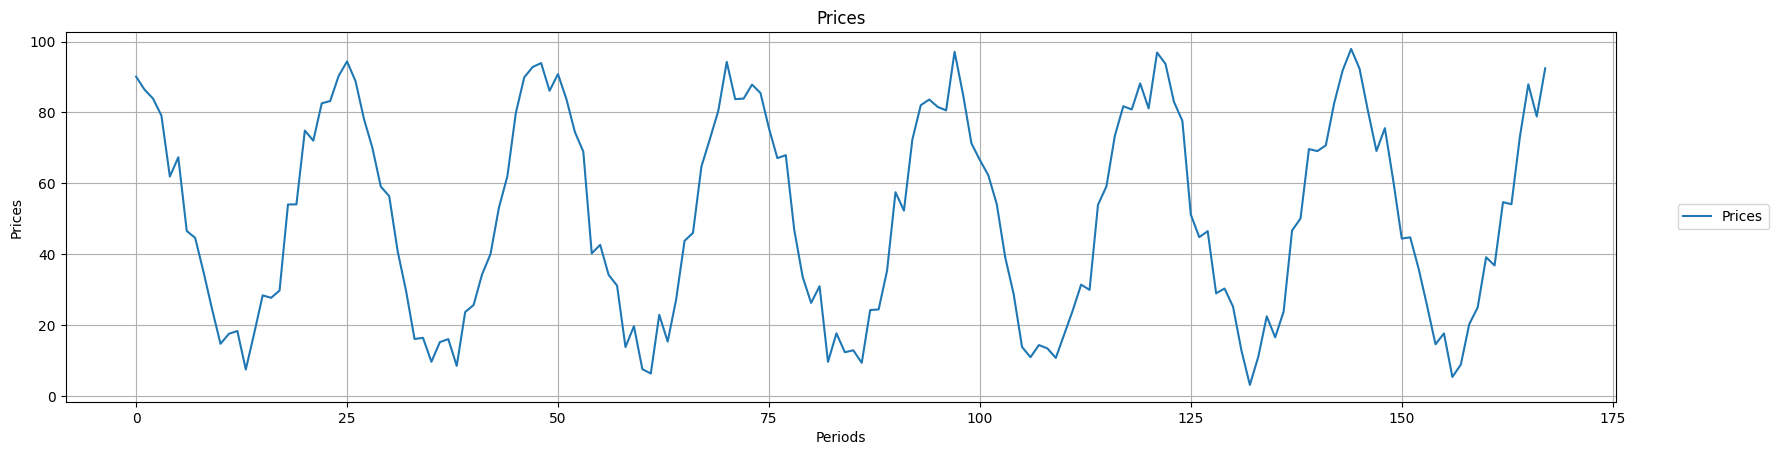

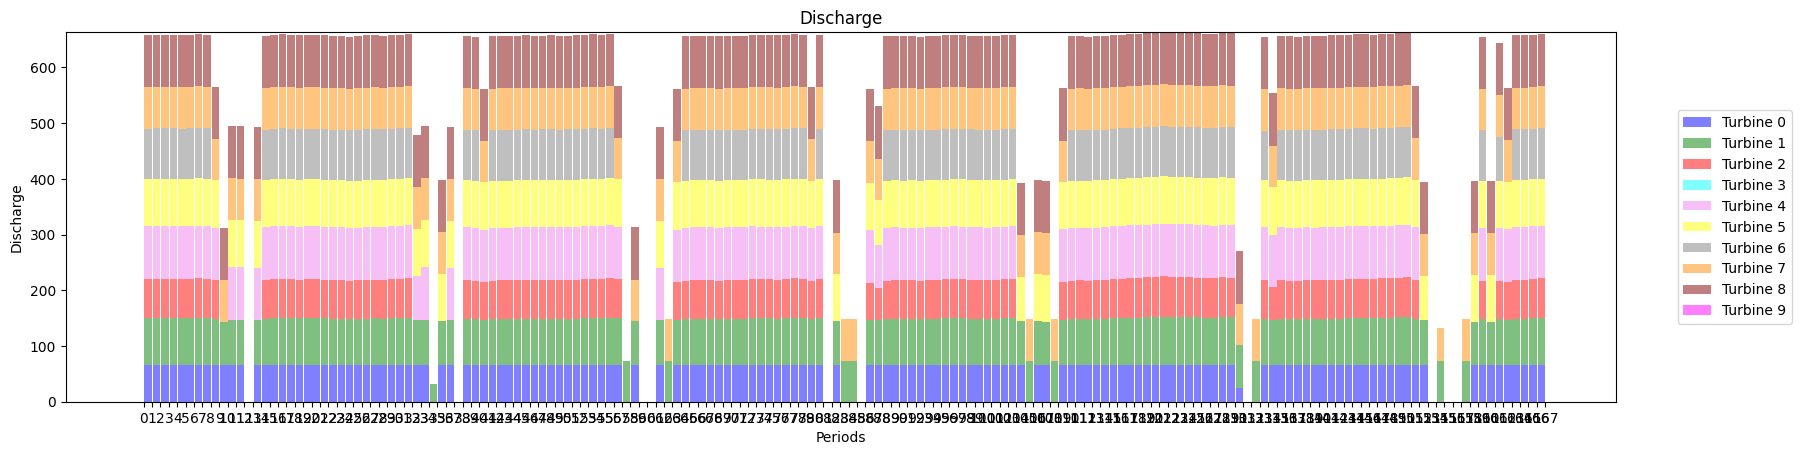

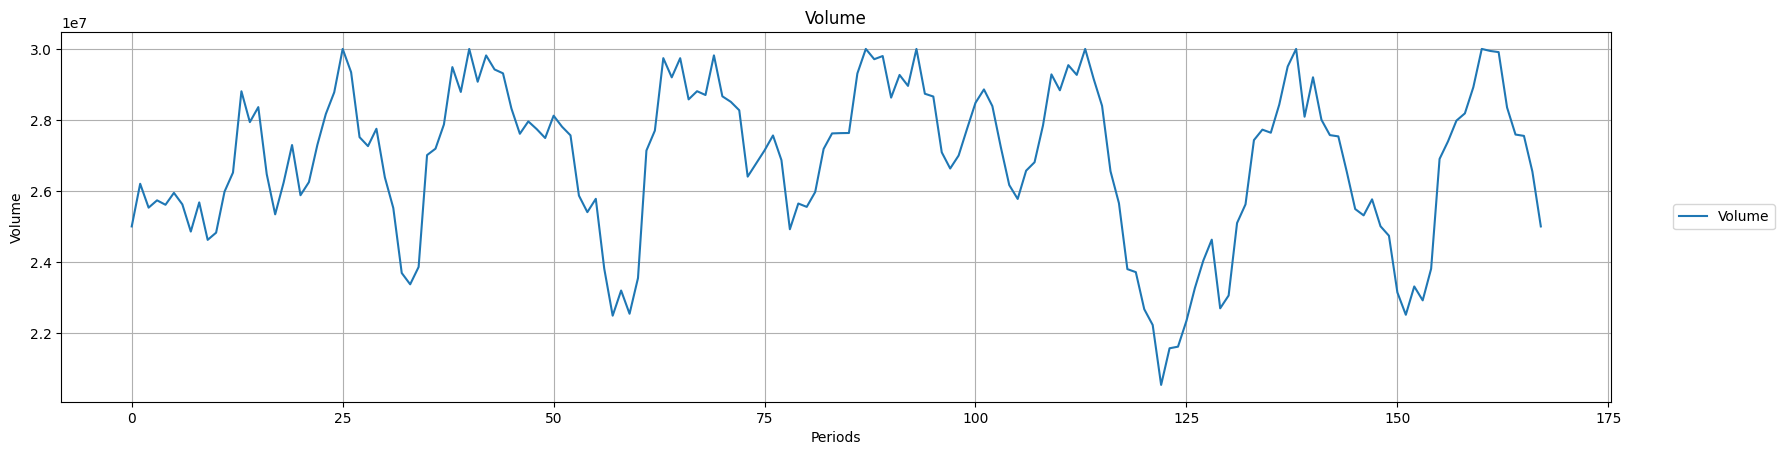

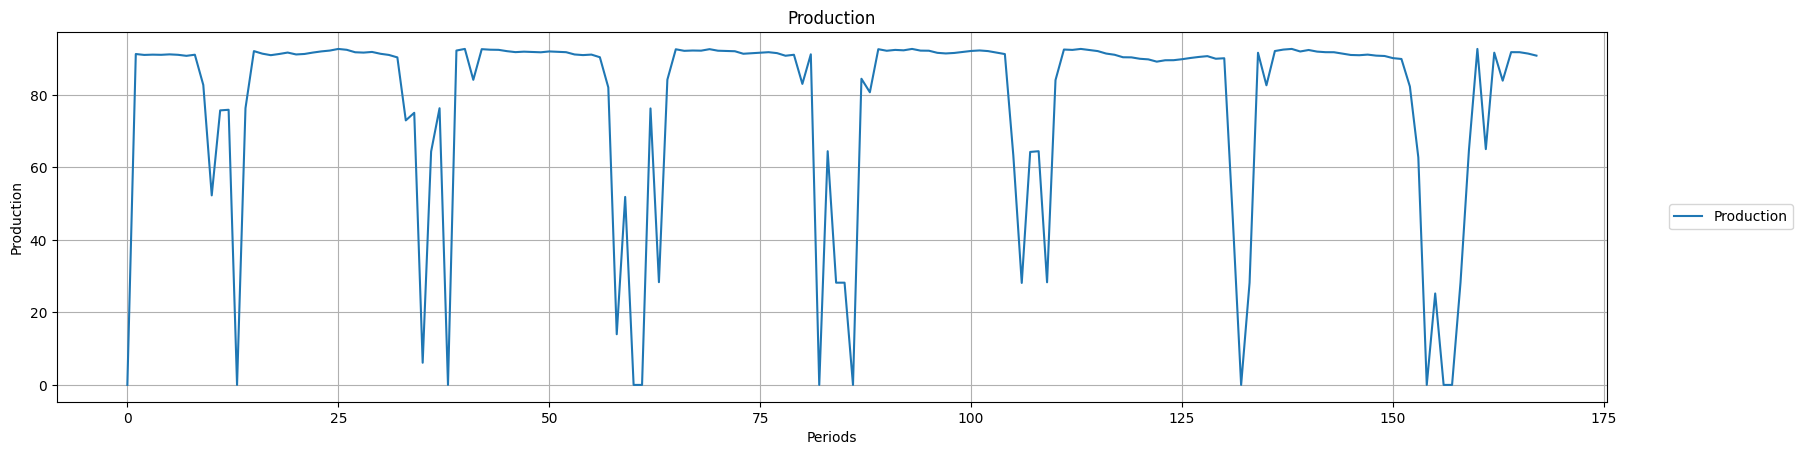

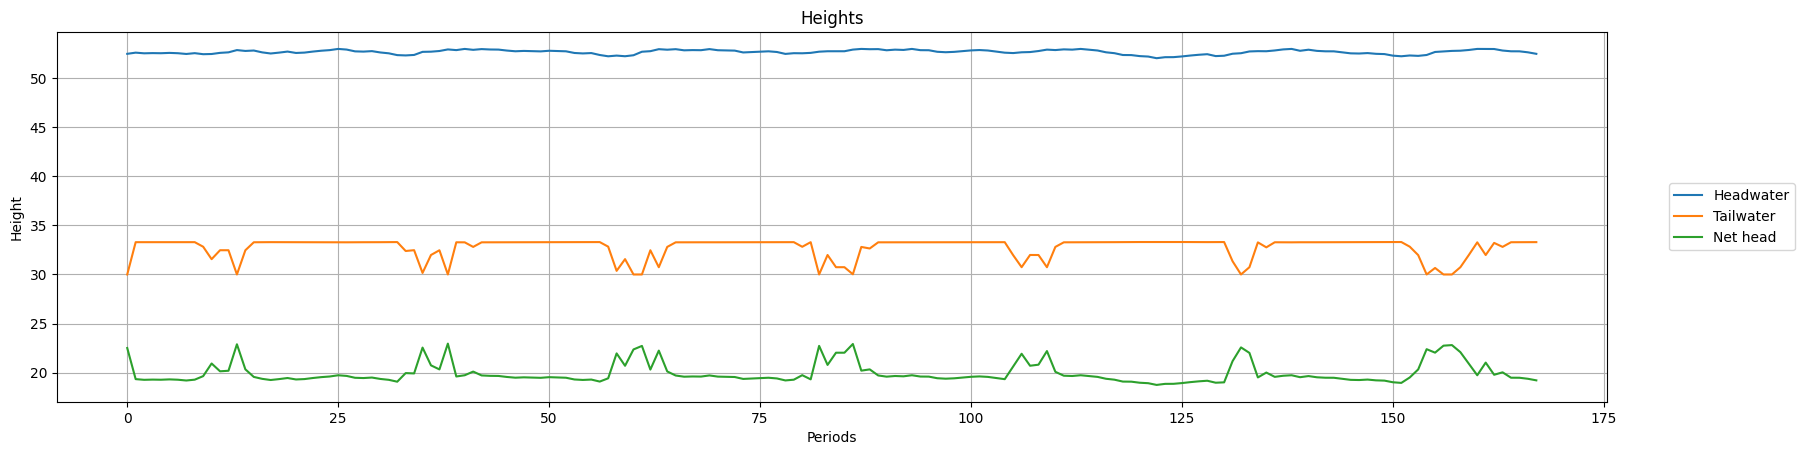

In [10]:
import matplotlib.pyplot as plt
import numpy as np

figwidth = 20
indices = np.arange(h)

# Plot prices.
plt.figure().set_figwidth(figwidth)
plt.plot(indices, [instance.periods[t].profit for t in range(h)], label="Prices")
plt.grid(True)
plt.ylabel("Prices")
plt.xlabel("Periods")
plt.title("Prices")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Plot solution, discharge for each turbine.
plt.figure().set_figwidth(figwidth)
width = 0.9
colors = [
    "blue",
    "green",
    "red",
    "cyan",
    "violet",
    "yellow",
    "grey",
    "darkorange",
    "maroon",
    "magenta",
    "lightblue",
    "lightcoral",
    "bisque",
    "slateblue",
]
bottom = [0 for _ in range(h)]
for j in range(n):
    values = [solution["q"][j, t] for t in range(h)]
    plt.bar(
        indices,
        values,
        width=width,
        alpha=0.5,
        color=colors[j],
        label="Turbine " + str(j),
        bottom=bottom,
    )
    plt.xticks(indices + 0.5 * width, ["{}".format(idx) for idx in range(h)])
    for t in range(h):
        bottom[t] += values[t]
plt.title("Discharge")
plt.xlabel("Periods")
plt.ylabel("Discharge")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Plot reservoir volume.
plt.figure().set_figwidth(figwidth)
plt.plot(indices, [solution["v"][t] for t in range(h)], label="Volume")
plt.grid(True)
plt.ylabel("Volume")
plt.xlabel("Periods")
plt.title("Volume")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Plot production.
plt.figure().set_figwidth(figwidth)
plt.plot(
    indices,
    [sum(solution["p"][j, t] for j in range(n)) for t in range(h)],
    label="Production",
)
plt.grid(True)
plt.ylabel("Production")
plt.xlabel("Periods")
plt.title("Production")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Plot headwater, tailwater and net head.
plt.figure().set_figwidth(figwidth)
plt.plot(indices, [solution["h_head"][t] for t in indices], label="Headwater")
plt.plot(indices, [solution["h_tail"][t] for t in indices], label="Tailwater")
plt.plot(indices, [solution["h_net"][t] for t in indices], label="Net head")
plt.grid(True)
plt.ylabel("Height")
plt.xlabel("Periods")
plt.title("Heights")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()